<a href="https://colab.research.google.com/github/bominwang/Bayesian-statistics-method/blob/bayesian-model-averaging-method/BNN_blitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')
# 这里一定要加绝对绝对路径os.path.abspath
path = '/content/drive/MyDrive/Colab Notebooks/bm_wang/Bayesian_statistics_method/bayesian_model_averaging'
sys.path.append(os.path.abspath(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from functools import partial
import tqdm
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

In [3]:
import sklearn
import sklearn.preprocessing

In [4]:
!pip install blitz-bayesian-pytorch
import blitz
import blitz.modules
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
def generating_sample(func, var_inforamtion, num_train, num_test):

  num = num_train + num_test
  num = int(num)
  # sampling for inputs
  ins = np.zeros(shape = [num, 1])
  var_num = len(var_inforamtion)
  for i in range(var_num):
    distribution_infromation = var_inforamtion[f'var_{i}']
    distribution_name = distribution_infromation[0]
    disrtibution_loc = distribution_infromation[1]
    disrtibution_scale = distribution_infromation[2]
    samples = getattr(np.random, distribution_name)(disrtibution_loc, disrtibution_scale, size = [num, 1])
    ins = np.append(ins, samples, axis = 1)
  ins = np.delete(ins, 0, axis = 1)
  # calculating for response
  labs = func(ins)
  
  ins = sklearn.preprocessing.StandardScaler().fit_transform(ins)
  labs = sklearn.preprocessing.StandardScaler().fit_transform(labs.reshape(-1,1))
  # transformation from numpy.array to torch.tensor
  
  ins = torch.from_numpy(ins).float()
  labs = torch.from_numpy(labs).float()
  
  # split to train_set and test_set
  train_volume = int(num_train)
  data_index = list(range(num))
  
  train_index = random.sample(range(0, num), train_volume)
  test_index = np.setdiff1d(data_index, train_index)

  train_ins, train_labs = ins[train_index, :], labs[train_index, :]
  test_ins, test_labs = ins[test_index, :], labs[test_index, :]

  # packaging by DataLoader and TensorDataset
  train_set = TensorDataset(train_ins, train_labs)
  train_set = DataLoader(train_set, batch_size = train_volume)
  
  test_set = TensorDataset(test_ins, test_labs)
  test_set = DataLoader(test_set, batch_size = train_volume)

  return train_set, test_set

In [6]:
@variational_estimator
class BayesianLinearRegression(nn.Module):

  def __init__(self, in_features, out_features):
    super().__init__()

    self.fc_1 = nn.Linear(in_features, in_features * 50)
    self.fc_2 = nn.Linear(in_features * 50, in_features * 100)
    self.fc_3 = nn.Linear(in_features * 100, in_features * 50)
    self.fc_4 = BayesianLinear(in_features * 50, out_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc_1(x))
    x = self.relu(self.fc_2(x))
    x = self.relu(self.fc_3(x))
    y = self.fc_4(x)
    
    return y

In [7]:
def evaluate(model, test_set, num_samples, std_multiplier, iterior):

  for index, (x_test, y_test) in enumerate(test_set):
    
    preds = [model(x_test) for i in range(num_samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    
    ic_acc = (ci_lower <= y_test) * (ci_upper >= y_test)
    ic_acc = ic_acc.float().mean()

    plt.figure(iterior)
    count = list(range(means.shape[0]))
    plt.scatter(count, y_test, color = 'black')
    plt.plot(count, means.detach().numpy(), color = 'blue')
    
    plt.fill_between(count, means.squeeze().detach().numpy(), ci_lower.squeeze().detach().numpy())
    
    plt.title(f'the error bar of the mdoel trained {iterior}th in test set ')
    plt.xlabel('Index of test data')
    plt.ylabel('Response')
    plt.show()
    print(f"the accuracy in test set is {ic_acc}")
  
  return means, stds

In [8]:
def training_precess(model, train_set, test_set, train_epoch):

  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  criterion = torch.nn.SmoothL1Loss()
  #criterion = torch.nn.MSELoss()
  loss_hist = []
  for epoch in trange(train_epoch):
    for index, (x_train, y_train) in enumerate(train_set):
      optimizer.zero_grad()
      loss = model.sample_elbo(inputs = x_train, labels = y_train, criterion = criterion, sample_nbr = 3, complexity_cost_weight = 1 / x_train.shape[0])
      loss_hist.append(loss.item())
      
      loss.backward()
      optimizer.step()
    
    if epoch % 500 == 0:
      evaluate(model, test_set, num_samples = 100, std_multiplier = 2, iterior = epoch)
  
  plt.figure(epoch)
  plt.plot(loss_hist)
  
  return model

In [9]:
from bma_demo import Mathematical_examples_1
inf_model1 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.924 - 0.05 * 1.925, 1.924 + 0.05 * 1.924], 'var_2': ["uniform", 0.6 - 0.05 * 0.6, 0.6 + 0.05 * 0.6]}
inf_model2 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 0.995 - 0.05 * 0.995, 0.995 + 0.05 * 0.995], 'var_2': ["uniform", 24.65 - 0.05 * 24.65, 24.65 + 0.05 * 24.65]}
inf_model3 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 2.265 - 0.05 * 2.265, 2.265 + 0.05 * 2.265], 'var_2': ["uniform", 364.21 - 0.05 * 364.21, 364.21 + 0.05 * 364.21], 'var_3': ["uniform", 0.3 - 0.05 *  0.3, 0.3 + 0.05 *  0.3]}
inf_model4 = {'var_0': ["uniform", 1, 360], 'var_1': ["uniform", 1.541 - 0.05 * 1.541, 1.541 + 0.05 * 1.541], 'var_2': ["uniform", 0.097 - 0.05 * 0.097, 0.097 + 0.05 * 0.097], 'var_3': ["uniform", 0.6 - 0.05 *  0.6, 0.6 + 0.05 *  0.6]}
batch_size = 100
trainset_model1, testset_model1 = generating_sample(Mathematical_examples_1.func_1, inf_model1, batch_size, 50)
trainset_model2, testset_model2 = generating_sample(Mathematical_examples_1.func_2, inf_model2, batch_size, 50)
trainset_model3, testset_model3 = generating_sample(Mathematical_examples_1.func_3, inf_model3, batch_size, 50)
trainset_model4, testset_model4 = generating_sample(Mathematical_examples_1.func_4, inf_model4, batch_size, 50)
for i, (x, y) in enumerate(trainset_model1):
  print(f'ins shape of train data{x.shape}')
  print(f'labs shape of train data{y.shape}')

ins shape of train datatorch.Size([100, 3])
labs shape of train datatorch.Size([100, 1])


  0%|          | 0/5000 [00:00<?, ?it/s]

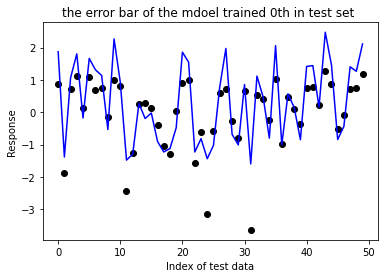

the accuracy in test set is 0.0


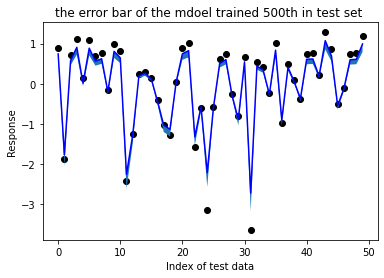

the accuracy in test set is 0.5799999833106995


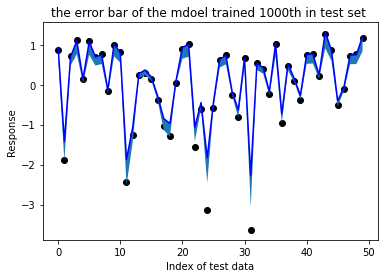

the accuracy in test set is 0.8399999737739563


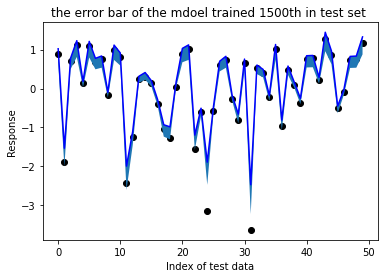

the accuracy in test set is 0.9599999785423279


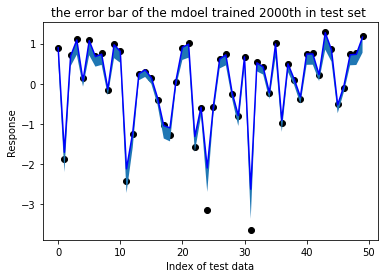

the accuracy in test set is 0.9599999785423279


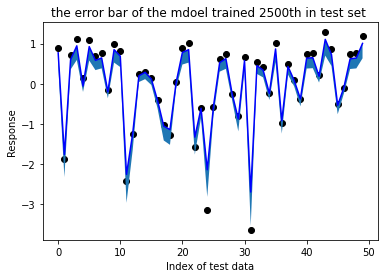

the accuracy in test set is 0.9399999976158142


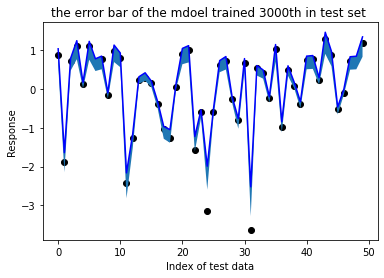

the accuracy in test set is 0.9599999785423279


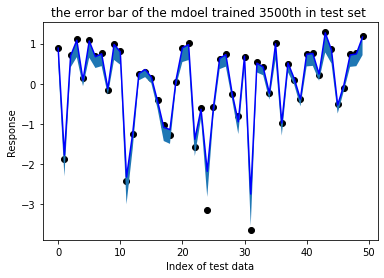

the accuracy in test set is 0.9599999785423279


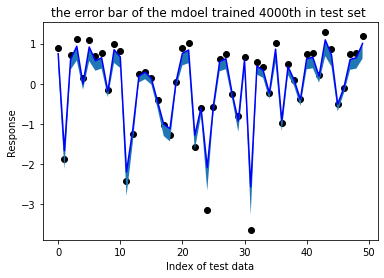

the accuracy in test set is 0.9599999785423279


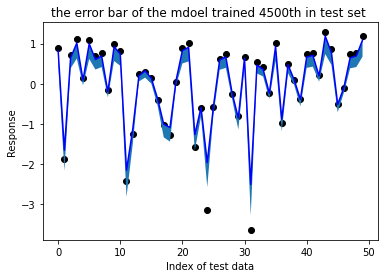

the accuracy in test set is 0.9599999785423279


BayesianLinearRegression(
  (fc_1): Linear(in_features=3, out_features=150, bias=True)
  (fc_2): Linear(in_features=150, out_features=300, bias=True)
  (fc_3): Linear(in_features=300, out_features=150, bias=True)
  (fc_4): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (relu): ReLU()
)

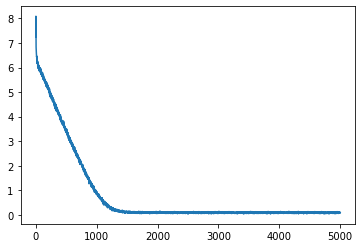

In [10]:
func1 = BayesianLinearRegression(3, 1)
training_precess(func1, trainset_model1, testset_model1, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

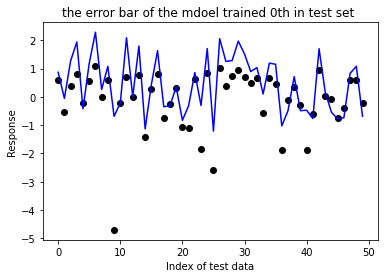

the accuracy in test set is 0.0


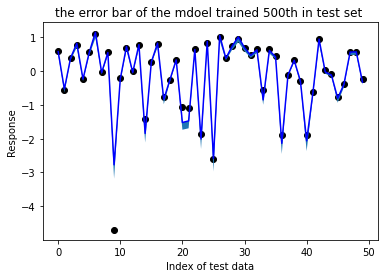

the accuracy in test set is 0.8600000143051147


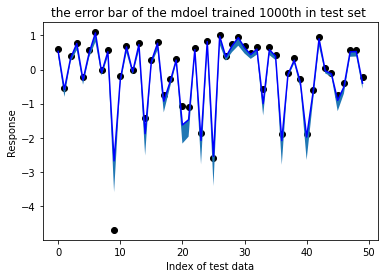

the accuracy in test set is 0.9200000166893005


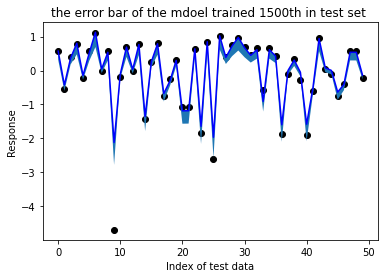

the accuracy in test set is 0.9200000166893005


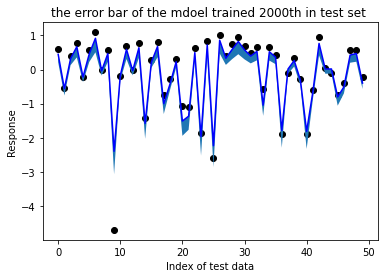

the accuracy in test set is 0.9200000166893005


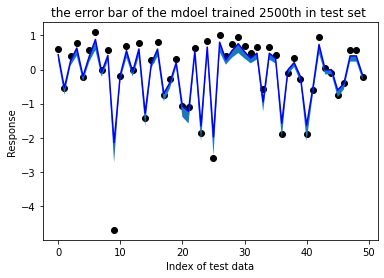

the accuracy in test set is 0.8600000143051147


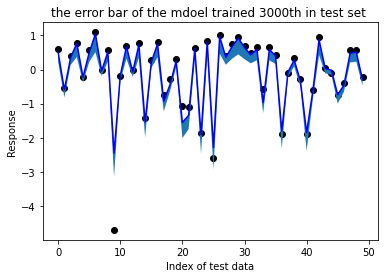

the accuracy in test set is 0.9399999976158142


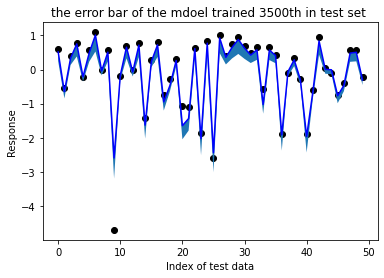

the accuracy in test set is 0.9200000166893005


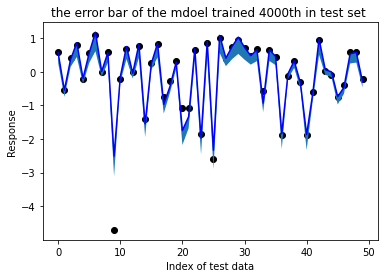

the accuracy in test set is 0.9399999976158142


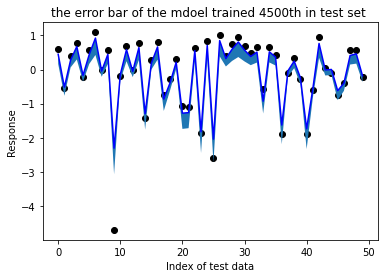

the accuracy in test set is 0.9599999785423279


BayesianLinearRegression(
  (fc_1): Linear(in_features=3, out_features=150, bias=True)
  (fc_2): Linear(in_features=150, out_features=300, bias=True)
  (fc_3): Linear(in_features=300, out_features=150, bias=True)
  (fc_4): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (relu): ReLU()
)

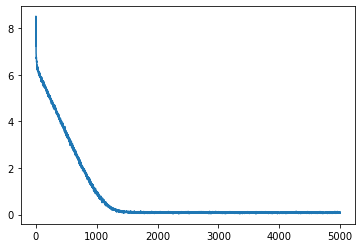

In [11]:
func2 = BayesianLinearRegression(3, 1)
training_precess(func2, trainset_model2, testset_model2, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

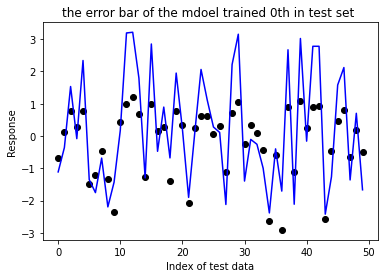

the accuracy in test set is 0.0


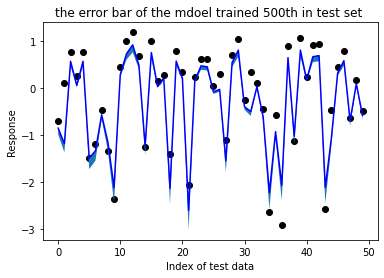

the accuracy in test set is 0.14000000059604645


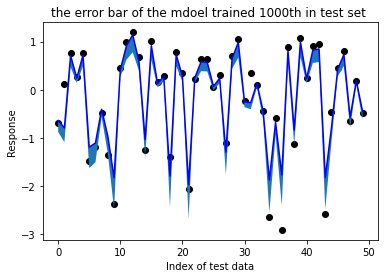

the accuracy in test set is 0.8600000143051147


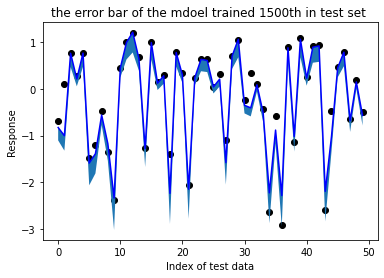

the accuracy in test set is 0.8799999952316284


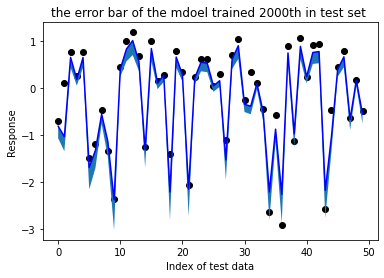

the accuracy in test set is 0.8600000143051147


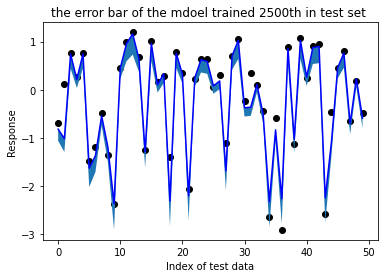

the accuracy in test set is 0.8600000143051147


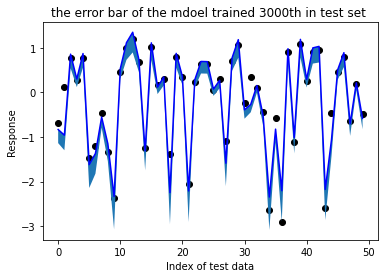

the accuracy in test set is 0.8999999761581421


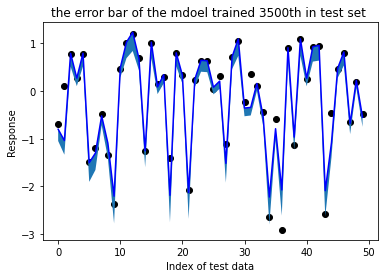

the accuracy in test set is 0.8799999952316284


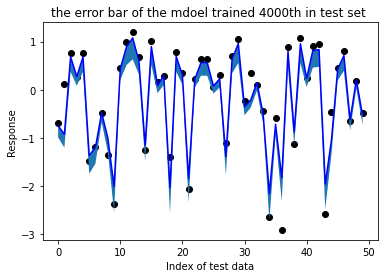

the accuracy in test set is 0.8600000143051147


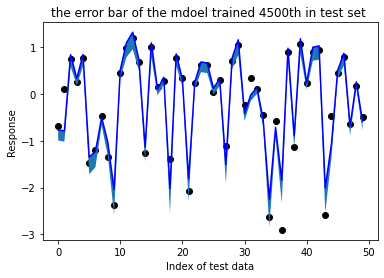

the accuracy in test set is 0.8399999737739563


BayesianLinearRegression(
  (fc_1): Linear(in_features=4, out_features=200, bias=True)
  (fc_2): Linear(in_features=200, out_features=400, bias=True)
  (fc_3): Linear(in_features=400, out_features=200, bias=True)
  (fc_4): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (relu): ReLU()
)

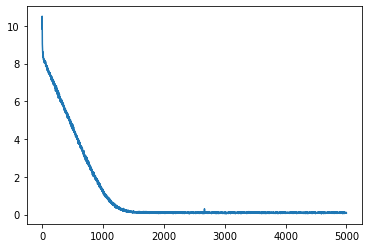

In [12]:
func3 = BayesianLinearRegression(4, 1)
training_precess(func3, trainset_model3, testset_model3, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

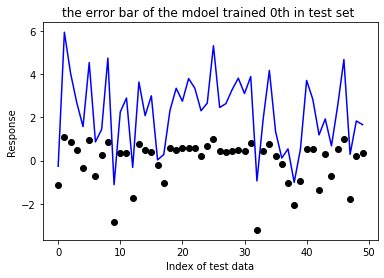

the accuracy in test set is 0.0


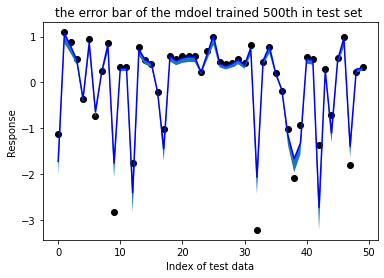

the accuracy in test set is 0.800000011920929


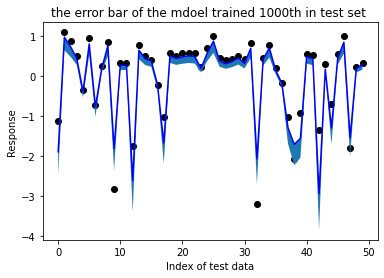

the accuracy in test set is 0.8199999928474426


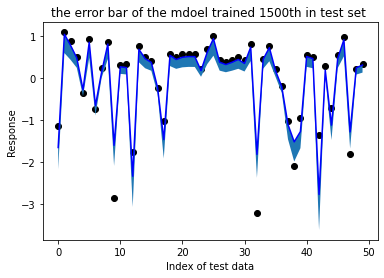

the accuracy in test set is 0.8799999952316284


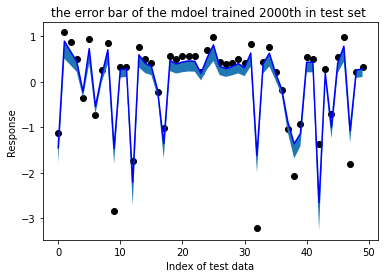

the accuracy in test set is 0.8199999928474426


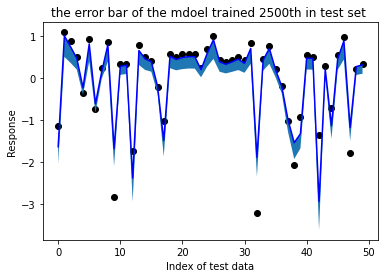

the accuracy in test set is 0.800000011920929


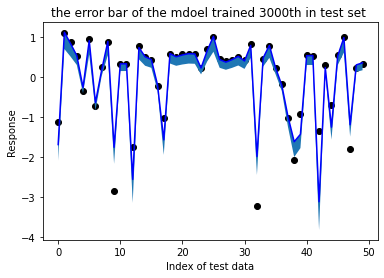

the accuracy in test set is 0.800000011920929


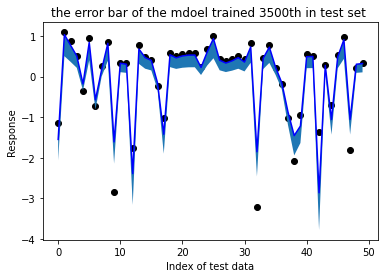

the accuracy in test set is 0.8799999952316284


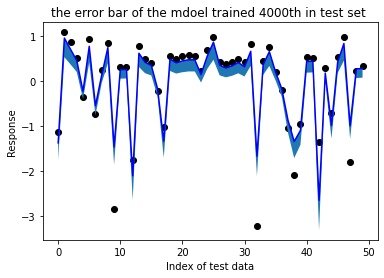

the accuracy in test set is 0.8999999761581421


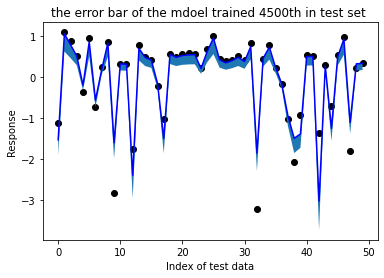

the accuracy in test set is 0.7799999713897705


BayesianLinearRegression(
  (fc_1): Linear(in_features=4, out_features=200, bias=True)
  (fc_2): Linear(in_features=200, out_features=400, bias=True)
  (fc_3): Linear(in_features=400, out_features=200, bias=True)
  (fc_4): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (relu): ReLU()
)

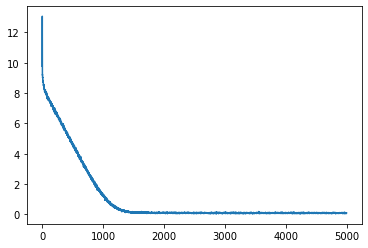

In [13]:
func4 = BayesianLinearRegression(4, 1)
training_precess(func4, trainset_model4, testset_model4, 5000)